In [4]:
!pip install facenet_pytorch
!pip install transforms
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 40.1 MB/s eta 0:00:00


In [30]:
import os
import faiss
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.decomposition import PCA

In [6]:
!gdown 1w7Riq_itzcijqkvSW0yyivvlw0IgRGa_
!unzip Dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1w7Riq_itzcijqkvSW0yyivvlw0IgRGa_
To: /content/Dataset.zip
100% 1.34M/1.34M [00:00<00:00, 101MB/s]
Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/Avatar_Aaron_Eckhart.jpg  
  inflating: Dataset/Avatar_Aaron_Guiel.jpg  
  inflating: Dataset/Avatar_Amy_Pascal.jpg  
  inflating: Dataset/Avatar_Amy_Redford.jpg  
  inflating: Dataset/Avatar_Andrew_Bernard.jpg  
  inflating: Dataset/Avatar_Andrew_Cuomo.jpg  
  inflating: Dataset/Avatar_Anh_Khoi.JPG  
  inflating: Dataset/Avatar_Anil_Ramsook.jpg  
  inflating: Dataset/Avatar_Camille_Lewis.jpg  
  inflating: Dataset/Avatar_Carla_Gay_Balingit.jpg  
  inflating: Dataset/Avatar_Dang_Nha.jpg  
  inflating: Dataset/Avatar_Hoang_Nguyen.jpg  
  inflating: Dataset/Avatar_Minh_Chau.jpg  
  inflating: Dataset/Avatar_Phuc_Thinh.JPG  
  inflating: Dataset/Avatar_Quoc_Thai.JPG  
  inflating: Dataset/Avatar_Thang_Duong.jpg  
  inflating: Dataset/Avatar_Thuan_Duong.jpg  
  inflating: Datas

In [7]:
DATASET_PATH = 'Dataset'
os.listdir(DATASET_PATH)
image_paths = []
labels = []

for filename in os.listdir(DATASET_PATH):
  if filename.endswith(('.jpg', '.JPG', '.PNG', '.jpeg')):
    image_paths.append(os.path.join(DATASET_PATH, filename))
    file_name = filename.split('.')[0]
    label = file_name[7:]
    labels.append(label)

In [8]:
IMAGE_SIZE = 300
VECTOR_DIM = 300 * 300 * 3

In [9]:
index = faiss.IndexFlatL2(VECTOR_DIM)
label_map = []

In [10]:
def image_to_vector(image_path):
  img = Image.open(image_path).resize((IMAGE_SIZE, IMAGE_SIZE))
  img_array = np.array(img)

  if len(img_array.shape) == 2:  # convert grayscale to RGB if grayscale
    img_array = np.stack((img_array,)*3, axis=-1)

  vector = img_array.astype('float32') / 255.0  # normalize to [0, 1]
  return vector.flatten()

In [11]:
image_paths

['Dataset/Avatar_Andrew_Cuomo.jpg',
 'Dataset/Avatar_Anil_Ramsook.jpg',
 'Dataset/Avatar_Aaron_Guiel.jpg',
 'Dataset/Avatar_Amy_Redford.jpg',
 'Dataset/Avatar_Minh_Chau.jpg',
 'Dataset/Avatar_Thuan_Duong.jpg',
 'Dataset/Avatar_Anh_Khoi.JPG',
 'Dataset/Avatar_Amy_Pascal.jpg',
 'Dataset/Avatar_Aaron_Eckhart.jpg',
 'Dataset/Avatar_Carla_Gay_Balingit.jpg',
 'Dataset/Avatar_Tien_Huy.jpg',
 'Dataset/Avatar_Phuc_Thinh.JPG',
 'Dataset/Avatar_Dang_Nha.jpg',
 'Dataset/Avatar_Camille_Lewis.jpg',
 'Dataset/Avatar_Quoc_Thai.JPG',
 'Dataset/Avatar_Hoang_Nguyen.jpg',
 'Dataset/Avatar_Andrew_Bernard.jpg',
 'Dataset/Avatar_Thang_Duong.jpg']

In [12]:
labels

['Andrew_Cuomo',
 'Anil_Ramsook',
 'Aaron_Guiel',
 'Amy_Redford',
 'Minh_Chau',
 'Thuan_Duong',
 'Anh_Khoi',
 'Amy_Pascal',
 'Aaron_Eckhart',
 'Carla_Gay_Balingit',
 'Tien_Huy',
 'Phuc_Thinh',
 'Dang_Nha',
 'Camille_Lewis',
 'Quoc_Thai',
 'Hoang_Nguyen',
 'Andrew_Bernard',
 'Thang_Duong']

In [13]:
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

for idx, row in df.iterrows():
  image_path = row['image_path']
  label = row['label']

  try:
    vector = image_to_vector(image_path)
    index.add(np.array([vector]))
    label_map.append(label)

  except Exception as error:
    print(f'Error processing {image_path}: {error}')

In [14]:
faiss.write_index(index, 'employee_images.index')
np.save('label_map.npy', np.array(label_map))

In [15]:
def search_similar_images(query_image_path, k=5):
  index = faiss.read_index('employee_images.index')
  label_map = np.load('label_map.npy')

  query_vector = image_to_vector(query_image_path)

  distances , indices = index.search(np.array([query_vector]), k)
  results = []
  for i in range(len(indices[0])):
    employee_name = label_map[indices[0][i]]
    distance = distances[0][i]
    results.append((employee_name, distance))

  return results

In [16]:
def display_query_and_top_matches(query_image_path):
  query_img = Image.open(query_image_path)
  query_img = query_img.resize((300, 300))

  plt.figure(figsize=(5, 5))
  plt.imshow(query_img)
  plt.title('Query Image')
  plt.axis('off')
  plt.show()

  matches = search_similar_images(query_image_path)

  top_matches = []
  for name, distance in matches:
    img_path = df[df['label'] == name]['image_path'].values[0]
    top_matches.append((name, distance, img_path))
  top_matches

  plt.figure(figsize=(15, 5))
  for i, (name, distance, img_path) in enumerate(top_matches):
    img = Image.open(img_path)
    img = img.resize((300, 300))

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'{name}\nDist: {distance}')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

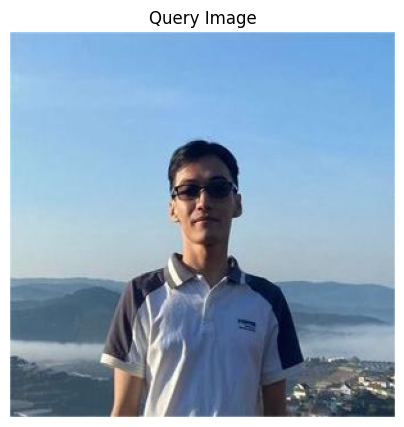

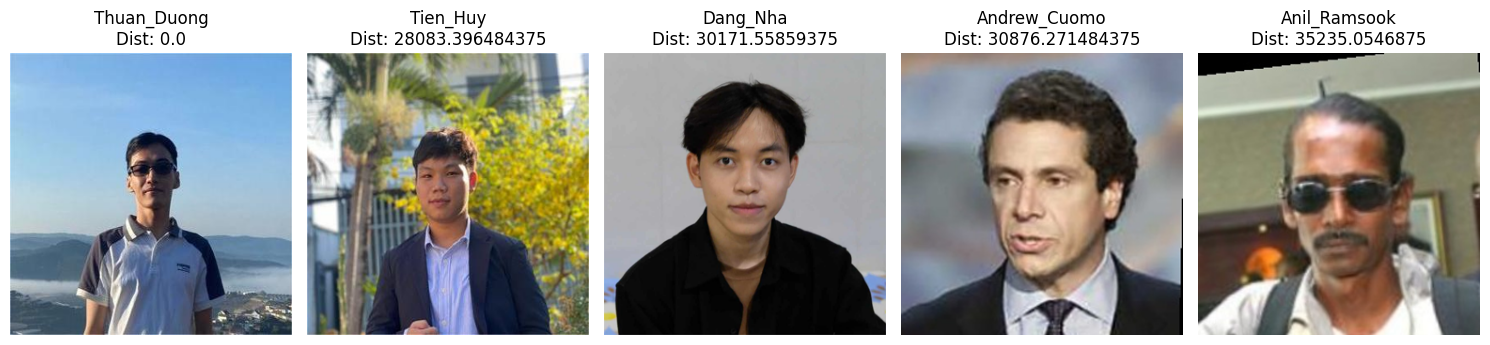

In [17]:
query_image_path1 = "/content/Dataset/Avatar_Thuan_Duong.jpg"
display_query_and_top_matches(query_image_path1)

In [18]:
face_regconition_model = InceptionResnetV1(pretrained='vggface2').eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [19]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [20]:
def extract_feature(image_path, model):
  img = Image.open(image_path).convert('RGB')
  img_tensor = transform(img).unsqueeze(0)
  with torch.no_grad():
    features = model(img_tensor)

  return features.squeeze().numpy()

In [21]:
VECTOR_DIM = 512
index = faiss.IndexFlatIP(VECTOR_DIM)
label_map = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
  features = extract_feature(row['image_path'], face_regconition_model)
  index.add(np.array([features]))
  label_map.append(row['label'])

100%|██████████| 18/18 [00:05<00:00,  3.05it/s]


In [22]:
label_map

['Andrew_Cuomo',
 'Anil_Ramsook',
 'Aaron_Guiel',
 'Amy_Redford',
 'Minh_Chau',
 'Thuan_Duong',
 'Anh_Khoi',
 'Amy_Pascal',
 'Aaron_Eckhart',
 'Carla_Gay_Balingit',
 'Tien_Huy',
 'Phuc_Thinh',
 'Dang_Nha',
 'Camille_Lewis',
 'Quoc_Thai',
 'Hoang_Nguyen',
 'Andrew_Bernard',
 'Thang_Duong']

In [23]:
faiss.write_index(index, 'facenet_features.index')
np.save('facenet_label_map.npy', np.array(label_map))

In [24]:
def image_to_feature(image_path, model):
  img = Image.open(image_path).convert('RGB') # Added .convert('RGB') to handle grayscale images
  img_tensor = transform(img).unsqueeze(0)
  with torch.no_grad():
    embedding = model(img_tensor)

  return embedding.squeeze().numpy()

In [25]:
def search_similar_images(query_image_path, k=5):
  index = faiss.read_index('facenet_features.index')
  label_map = np.load('facenet_label_map.npy')

  query_vector = image_to_feature(query_image_path, face_regconition_model)

  similarities, indices = index.search(np.array([query_vector]), k)

  results = []
  for i in range(len(indices[0])):
    employee_name = label_map[indices[0][i]]
    similarity = similarities[0][i]
    results.append((employee_name, similarity))

  return results

In [26]:
def display_query_and_top_matches(query_image_path):
  query_img = Image.open(query_image_path)
  query_img = query_img.resize((300, 300))

  plt.figure(figsize=(5, 5))
  plt.imshow(query_img)
  plt.title('Query Image')
  plt.axis('off')
  plt.show()

  matches = search_similar_images(query_image_path)

  plt.figure(figsize=(15, 5))
  for i, (name, similarity) in enumerate(matches):
    img_path = df[df['label'] == name]['image_path'].values[0]
    img = Image.open(img_path)
    img = img.resize((300, 300))

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'{name}\nSimilarity: {similarity}')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

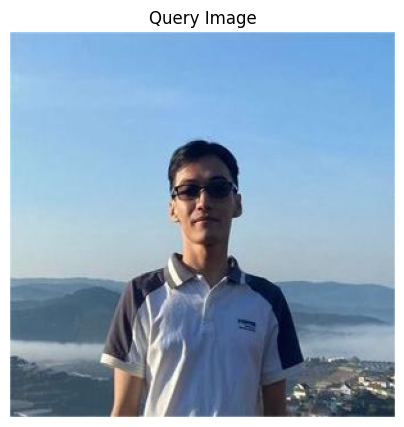

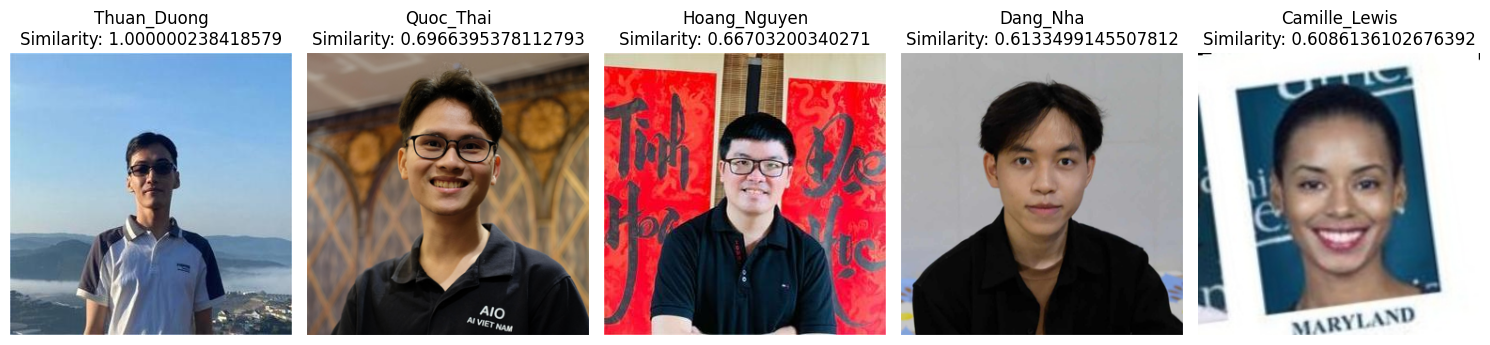

In [27]:
query_image_path1 = "/content/Dataset/Avatar_Thuan_Duong.jpg"
display_query_and_top_matches(query_image_path1)

BUILD APP

In [31]:
%%writefile app.py
import os
import streamlit as st
import cv2
from PIL import Image, ImageOps
import numpy as np
import faiss
import torch
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import base64
from io import BytesIO

st.set_page_config(page_title='Employee Checkin Dashboard', layout='wide')

@st.cache_resource
def load_facenet_model():
  return InceptionResnetV1(pretrained='vggface2').eval()

@st.cache_resource
def load_faiss_index():
  if not os.path_exists('facenet_features.index') or not os.path.exists('facenet_label_map.npy'):
    st.error('Faiss index or label map not found!')
    return None, None, None

  index = faiss.read_index('facenet_features.index')
  label_map = np.load('facenet_label_map.npy')

  embeddings = index.reconstruct_n(0, index.ntotal)
  return index, label_map, embeddings

facenet_model = load_facenet_model()
index, label_map, embeddings = load_faiss_index()


transforms = transforms.Compose([
    transforms.Resize((160, 160)), #facenet expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


def crop_center_square(img):
  """Crop center square of img and resize to 300 * 300 """
  width, height = img.size
  size = min(width, height)
  left = (width - size) / 2
  top = (height - size) / 2
  right = (width + size) / 2
  bottom = (height + size) / 2

  img = img.crop((left, top, right, bottom))
  img = img.resize((300, 300))
  return img

def image_to_feature(image, model):
  img = image.convert('RGB')
  img_tensor = transform(img).unsqueeze(0)

  with torch.no_grad():
    embedding = model(img_tensor)
  return embedding.squeeze().numpy()

def search_similar_images(query_feature, k=5, threshold=0.3):
  if index is None or label_map is None:
    return []

  similarities, indices = index.search(np.array([query_feature]), k)
  results = []

  for i in range(len(indices[0])):
    similarity = similarities[0][i]
    if similarity > threshold:
      employee_name = label_map[indices[0][i]]
      results.append((employee_name, similarity, indices[0][i]))

  return results


def visualize_embeddings(query_embedding=None, matches=None):
    """Visualize embeddings in 3D space using t-SNE with highlighted points and similarity lines."""
    if all_embeddings is None or len(all_embeddings) < 3:
        st.warning("Not enough embeddings to visualize (need at least 3)")
        return

    # Prepare data for visualization
    embeddings_to_plot = all_embeddings.copy()
    labels = label_map.copy()
    colors = ['blue'] * len(all_embeddings)
    sizes = [8] * len(all_embeddings)
    # hover_names = [f"Employee: {name}" for name in labels]
    hover_names = []
    for i, name in enumerate(labels):
        if query_embedding is not None and i < len(all_embeddings):
            # Calculate similarity from this point to query
            dist = np.linalg.norm(all_embeddings[i] - query_embedding)
            hover_names.append(f"Employee: {name} (Dist: {dist:.4f})")
        else:
            hover_names.append(f"Employee: {name}")

    # Add query embedding if available
    query_idx = None
    if query_embedding is not None:
        query_idx = len(embeddings_to_plot)  # Store the index of the query point
        embeddings_to_plot = np.vstack([embeddings_to_plot, query_embedding])
        labels = np.append(labels, "Query Face")
        colors.append('red')
        sizes.append(12)
        hover_names.append("Your Face (Query)")

    # Highlight matches if available
    match_indices = []
    if matches:
        for i, (name, similarity, idx) in enumerate(matches):
            if idx < len(colors):  # Ensure we don't go out of bounds
                colors[idx] = 'green' if i == 0 else 'orange'  # Top match is green, others orange
                sizes[idx] = 12
                hover_names[idx] = f"Match {i+1}: {name} (Similarity: {similarity:.4f})"
                match_indices.append(idx)

    # Calculate appropriate perplexity (must be less than n_samples)
    n_samples = len(embeddings_to_plot)
    perplexity = min(30, max(5, n_samples - 1))  # Use 5-30 range, but always < n_samples

    # Reduce dimensionality with t-SNE (3D)
    # tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity)
    # embeddings_3d = tsne.fit_transform(embeddings_to_plot)

    pca = PCA(n_components=3, random_state=42)
    embeddings_3d = pca.fit_transform(embeddings_to_plot)
    # Create a DataFrame for Plotly (now with z-axis)
    df = pd.DataFrame({
        'x': embeddings_3d[:, 0],
        'y': embeddings_3d[:, 1],
        'z': embeddings_3d[:, 2],
        'label': labels,
        'color': colors,
        'size': sizes,
        'hover_name': hover_names
    })

    # Create 3D interactive plot
    fig = px.scatter_3d(
        df,
        x='x',
        y='y',
        z='z',
        color='color',
        size='size',
        hover_name='hover_name',
        title='Face Embeddings in 3D Space',
        color_discrete_map={
            'blue': 'rgba(30, 136, 229, 0.7)',  # Blue for employees
            'red': 'rgba(229, 57, 53, 1)',       # Red for query
            'green': 'rgba(67, 160, 71, 1)',     # Green for top match
            'orange': 'rgba(255, 152, 0, 1)'     # Orange for other matches
        }
    )

    # Add similarity lines between query and matches
    if query_embedding is not None and matches:
        for i, (name, similarity, idx) in enumerate(matches[:5]):  # Only show top 3 matches
            if idx < len(embeddings_3d):
                # Add a line between query and match
                fig.add_trace(
                    go.Scatter3d(
                        x=[embeddings_3d[query_idx, 0], embeddings_3d[idx, 0]],
                        y=[embeddings_3d[query_idx, 1], embeddings_3d[idx, 1]],
                        z=[embeddings_3d[query_idx, 2], embeddings_3d[idx, 2]],
                        mode='lines',
                        line=dict(
                            color='purple' if i == 0 else 'gray',
                            width=3 if i == 0 else 1
                        ),
                        showlegend=False,
                        hoverinfo='text',
                        hovertext=f"Similarity: {similarity:.4f}"
                    )
                )

    fig.update_layout(
        scene=dict(
            xaxis_title='Dimension 1',
            yaxis_title='Dimension 2',
            zaxis_title='Dimension 3',
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(l=0, r=0, b=0, t=30)
    )

    # Add annotations for matches
    if matches:
        for i, (name, similarity, idx) in enumerate(matches[:5]):  # Only annotate top 3
            if idx < len(embeddings_3d):
                fig.add_annotation(
                    x=embeddings_3d[idx, 0],
                    y=embeddings_3d[idx, 1],
                    text=f"Match {i+1}" if i > 0 else "Best Match",
                    showarrow=True,
                    arrowhead=1,
                    font=dict(size=12, color="black")
                )

    st.plotly_chart(fig, use_container_width=True)
    # Add a similarity table below the plot
    if matches:
        st.subheader("Match Distances")
        match_data = []
        for i, (name, similarity, idx) in enumerate(matches):
            match_data.append({
                "Rank": i+1,
                "Name": name,
                "Similarity": f"{similarity:.4f}",
            })

        df_matches = pd.DataFrame(match_data)
        st.dataframe(df_matches.style.highlight_max(subset=["Similarity"], color='lightgreen'),
                    use_container_width=True)


def get_avatar_image(employee_name):
    avatar_path_jpg = f"./Dataset/Avatar_{employee_name}.jpg"
    avatar_path_JPG = f"./Dataset/Avatar_{employee_name}.JPG"

    if os.path.exists(avatar_path_jpg):
      return avatar_path_jpg
    elif os.path.exists(avatar_path_JPG):
      return avatar_path_JPG
    else:
      return None


# State management
if 'checkin_status' not in st.session_state:
  if label_map is not None:
    st.session_state.checkin_status = {name: False for name in label_map}
  else:
    st.session_state.checkin_status = {}

if 'captured_img' not in st.session_state:
  st.session_state.captured_img = None

if 'matching_result' not in st.session_state:
  st.session_state.matching_result = None

if 'matching_distance' not in st.session_state:
  st.session_state.matching_distance = None

if "matching_avatar" not in st.session_state:
    st.session_state.matching_avatar = None

if "query_embedding" not in st.session_state:
    st.session_state.query_embedding = None

if "all_matches" not in st.session_state:
    st.session_state.all_matches = []


def main():
  col1, col2 = st.columns([3, 2])
  with col1:
    st.markdown('### Employee List')

    if not st.session_state.checkin_status:
      st.warning('No employee data available')
    else:
      cols = st.columns(3)
      for i, (name, checked) in enumerate(st.session_state.checkin_status.items()):
          with cols[i % 3]:
              avatar = get_avatar_image(name)
              print(avatar, i)
              status_class = "checked-in" if checked else "not-checked"
              status_text = "CHECKED IN" if checked else "NOT CHECKED"
              image = Image.open(avatar)

              image = image.resize((300, 300))

              st.image(image, use_container_width=True)


  with col2:
    # Check-in Section
    st.markdown("### 📸 Employee Check-in")

    # Camera capture button
    if st.button("Open Camera for Check-in", use_container_width=True, type="primary"):
        st.session_state.capture_clicked = True

    if st.session_state.get('capture_clicked', False):
        st.info("Preparing camera...")
        st.session_state.captured_image = None
        camera_placeholder = st.empty()
        countdown_placeholder = st.empty()

        cap = cv2.VideoCapture(0)
        captured_frame = None

        if not cap.isOpened():
            st.warning("📷 Could not access camera. Please upload an image instead.")
            uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])
            if uploaded_file is not None:
                captured_image = Image.open(uploaded_file).convert("RGB")
                captured_image = crop_center_square(captured_image)
                st.session_state.captured_image = captured_image
        else:
            start_time = time.time()
            capture_delay = 3  # 3-second countdown

            while (time.time() - start_time) < capture_delay:
                ret, frame = cap.read()
                if not ret:
                    st.error("Failed to capture frame")
                    break

                remaining = int(capture_delay - (time.time() - start_time)) + 1
                countdown_placeholder.markdown(
                    f"<h2 style='text-align:center;color:#ff5722;'>{remaining}</h2>",
                    unsafe_allow_html=True
                )

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                camera_placeholder.image(frame_rgb, channels="RGB", use_container_width=True)

                if (time.time() - start_time) >= (capture_delay - 0.1):
                    captured_frame = frame_rgb

                time.sleep(0.05)

            cap.release()
            camera_placeholder.empty()
            countdown_placeholder.empty()

            if captured_frame is not None:
                captured_image = Image.fromarray(captured_frame)
                captured_image = crop_center_square(captured_image)
                st.session_state.captured_image = captured_image

        # If we have a captured image (from camera or upload)
        if st.session_state.get('captured_image'):
            with st.spinner("🔍 Finding match..."):
                query_embedding = image_to_feature(st.session_state.captured_image, face_recognition_model)
                st.session_state.query_embedding = query_embedding

                matches = search_similar_features(query_embedding, k=5, threshold=0.3)
                st.session_state.all_matches = matches

                if matches:
                    best_match_name, best_distance, _ = matches[0]
                    st.session_state.checkin_status[best_match_name] = True
                    st.session_state.matching_result = best_match_name
                    st.session_state.matching_distance = best_distance
                    st.session_state.matching_avatar = get_avatar_image(best_match_name)
                    st.session_state.capture_clicked = False
                    st.rerun()
                else:
                    st.session_state.matching_result = None



    # Show captured image if available
    if st.session_state.captured_image is not None:
        st.markdown("---")
        st.markdown("### 📷 Captured Image")
        st.image(st.session_state.captured_image, use_container_width=True)

        # Show matching results
        if st.session_state.matching_result:
            st.success(f"""
            ✅ **{st.session_state.matching_result}** checked in!
            Similarity: {st.session_state.matching_distance:.4f}
            """)

            def image_to_base64(image_path, size=(300, 300)):
                img = Image.open(image_path).resize(size)
                buffered = BytesIO()
                img.save(buffered, format="PNG")
                return base64.b64encode(buffered.getvalue()).decode()

            # Show top matches
            st.markdown("### 🏆 Top Matches")
            inner_cols = st.columns(2)  # Create two columns inside col2

            for i, (name, similarity, _) in enumerate(st.session_state.all_matches[:5]):
                avatar = get_avatar_image(name)
                border_color = "#4CAF50" if i == 0 else "#FFC107"

                with inner_cols[i % 2]:  # Alternate between the two inner columns
                    st.markdown(f"""
                        <div style="border: 3px solid {border_color}; border-radius: 8px; padding: 5px; margin-bottom:10px; text-align: center;">
                            <img src="data:image/png;base64,{image_to_base64(avatar)}" style="width:100%; border-radius:6px;" />
                            <div style="margin-top:5px;">
                                <strong>{name}</strong><br>
                                <small>Similarity: {similarity:.4f}</small>
                            </div>
                        </div>
                    """, unsafe_allow_html=True)

            # Show vector space visualization
            st.markdown("### 🌌 Vector Space Visualization")
            st.markdown("""
            Each point represents a face embedding. The red point is your face,
            green is the best match, and orange are other potential matches.
            """)
            visualize_embeddings(
                st.session_state.query_embedding,
                [(name, dist, idx) for name, dist, idx in st.session_state.all_matches[:5]]
            )
        elif st.session_state.matching_result is None and st.session_state.all_matches:
            st.error("No matches found above the confidence threshold.")
            visualize_embeddings(st.session_state.query_embedding)

Overwriting app.py


In [37]:
!git clone git@github.com:Zackerville/Face-Base-Employee-Checkin-System.git
%cd /content/Face-Base-Employee-Checkin-System
!git config user.name "Zackerville"
!git config user.email "games.tien.minh@gmail.com"
!git add .
!git commit -m 'update'
!git push origin main

Cloning into 'Face-Base-Employee-Checkin-System'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/Face-Base-Employee-Checkin-System
hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> Face-Base-Employee-Checkin-System
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached Face-Base-Employee-Checkin-System
hint: 
hint: See "git help submodule" for more information.
[main c35982d] update
 1 file changed, 1 insertion(+)
 create mode 160000 Face-Base-Employee-Checkin-System
Enumerating objects: 3, done.
Counting objects: 100% (3/3), done.

In [38]:
!git push

Everything up-to-date


In [34]:
!mkdir -p ~/.ssh
!chmod 700 ~/.ssh

!ssh-keygen -t ed25519 -C "you@example.com" -f ~/.ssh/id_ed25519 -N ""

!ssh-keyscan github.com >> ~/.ssh/known_hosts
!chmod 644 ~/.ssh/known_hosts

!cat ~/.ssh/id_ed25519.pub


Generating public/private ed25519 key pair.
Your identification has been saved in /root/.ssh/id_ed25519
Your public key has been saved in /root/.ssh/id_ed25519.pub
The key fingerprint is:
SHA256:BevtCMo5Y8dSELAnhurYXfbWBIMY4MytCuRPG5NX8FQ you@example.com
The key's randomart image is:
+--[ED25519 256]--+
|  ooo. .oE       |
| = o ++. o       |
|..B = .o+ .      |
|+. +.... =       |
|o..= .= S o      |
|+ooo=B o =       |
|o..oX o + o      |
|   . = .         |
|                 |
+----[SHA256]-----+
# github.com:22 SSH-2.0-88f9acd9
# github.com:22 SSH-2.0-88f9acd9
# github.com:22 SSH-2.0-88f9acd9
# github.com:22 SSH-2.0-88f9acd9
# github.com:22 SSH-2.0-88f9acd9
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAILOQVdtlq9jYjyjukwDQEdWD6In2eSls2cfC0M928qoG you@example.com
